# IRFCL Analysis

**Countries:** Brazil, Germany, China, India, USA

## 1. Setup & Data Load

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Locate data
REPO_ROOT = Path.cwd()
while not (REPO_ROOT / '.git').exists() and REPO_ROOT != REPO_ROOT.parent:
    REPO_ROOT = REPO_ROOT.parent

irfcl_file = REPO_ROOT / 'part-00000-cf8618fc-2a1f-41b2-a46f-80a73d8423a5-c000.csv'
if not irfcl_file.exists():
    for base in [REPO_ROOT / 'Resultados', REPO_ROOT / 'base_dados' / 'Resultados']:
        if base.exists() and (candidates := list(base.glob('IRFCL.csv'))):
            irfcl_file = candidates[0]
            break

# Load data
COUNTRIES = ['BRA', 'DEU', 'CHN', 'IND', 'USA']
COUNTRY_NAMES = {'BRA': 'Brazil', 'DEU': 'Germany', 'CHN': 'China', 'IND': 'India', 'USA': 'USA'}

df_full = pd.read_csv(irfcl_file)
df_irfcl = df_full[df_full['COUNTRY'].isin(COUNTRIES)].copy()

# Extract IRFCL columns only
irfcl_cols = [col for col in df_irfcl.columns if 'IRFCL' in col and col != 'SECTOR_IRFCL']
df_irfcl = df_irfcl[['COUNTRY', 'TIME_PERIOD', 'FREQ'] + irfcl_cols].copy()

print(f"Records: {len(df_irfcl):,} | Indicators: {len(irfcl_cols)} | Period: {df_irfcl['TIME_PERIOD'].min()} - {df_irfcl['TIME_PERIOD'].max()}")

Records: 513 | Indicators: 24 | Period: 2000-Q1 - 2025-Q3


## 2. Data Quality

In [94]:
# Data completeness by country
for code in COUNTRIES:
    data = df_irfcl[df_irfcl['COUNTRY'] == code]
    completeness = data[irfcl_cols].notna().sum().sum() / (len(data) * len(irfcl_cols)) * 100
    print(f"{COUNTRY_NAMES[code]:10} {completeness:5.1f}% | {len(data):3} records")

Brazil      78.8% | 103 records
Germany     58.5% | 102 records
China       32.1% | 102 records
India       54.1% | 103 records
USA         32.4% | 103 records


## 3. Reserve Analysis

**Wide → Long transformation for indicator-level analysis**

In [105]:
# Transform to long format
df_long = df_irfcl.melt(
    id_vars=['COUNTRY', 'TIME_PERIOD', 'FREQ'],
    value_vars=irfcl_cols,
    var_name='INDICATOR',
    value_name='VALUE'
).dropna(subset=['VALUE'])

print(f"Long format: {df_long.shape[0]:,} rows | {df_long['INDICATOR'].nunique()} indicators\n")

# List all indicators found
print("Indicators found:")
for i, indicator in enumerate(sorted(df_long['INDICATOR'].unique()), 1):
    print(f"  {i:2d}. {indicator}")

Long format: 6,304 rows | 24 indicators

Indicators found:
   1. IRFCLDT1_IRFCL32_USD_IRFCL13
   2. IRFCLDT1_IRFCL54_USD_IRFCL13
   3. IRFCLDT1_IRFCL56_USD_IRFCL13
   4. IRFCLDT1_IRFCL57_USD_IRFCL13
   5. IRFCLDT1_IRFCL65_DIC_XDR_USD_IRFCL13
   6. IRFCLDT1_IRFCL65_USD_IRFCL13
   7. IRFCLDT1_IRFCLCDCFC_USD_IRFCL13
   8. IRFCLDT2_IRFCL151_SM1MUT3M_FO_USD_IRFCL13
   9. IRFCLDT2_IRFCL151_SM3MUTY_FO_USD_IRFCL13
  10. IRFCLDT2_IRFCL151_SUTM_FO_USD_IRFCL13
  11. IRFCLDT2_IRFCL1_SUTM_IN_LP_USD_IRFCL13
  12. IRFCLDT2_IRFCL1_SUTM_SHP_USD_IRFCL13
  13. IRFCLDT2_IRFCL24_SM1MUT3M_USD_IRFCL13
  14. IRFCLDT2_IRFCL24_SM3MUTY_USD_IRFCL13
  15. IRFCLDT2_IRFCL24_SUTM_USD_IRFCL13
  16. IRFCLDT2_IRFCL26_SM1MUT3M_FO_USD_IRFCL13
  17. IRFCLDT2_IRFCL26_SM3MUTY_FO_USD_IRFCL13
  18. IRFCLDT2_IRFCL26_SUTM_FO_USD_IRFCL13
  19. IRFCLDT2_USD_IRFCL13
  20. IRFCLDT4_IRFCL11_DIC_XDRB_USD_IRFCL13
  21. IRFCLDT4_IRFCL11_DIC_XXDR_USD_IRFCL13
  22. IRFCLDT4_IRFCL68_USD_IRFCL13
  23. IRFCLDT4_IRFCL69X_USD_IRFCL13
  24. IRF

### Reserve Levels & Composition

In [96]:
# Latest reserves & composition
total_col = 'IRFCLDT1_IRFCL65_USD_IRFCL13'
gold_col = 'IRFCLDT1_IRFCL56_USD_IRFCL13'
sec_col = 'IRFCLDT1_IRFCL32_USD_IRFCL13'
curr_col = 'IRFCLDT1_IRFCLCDCFC_USD_IRFCL13'
drains_col = 'IRFCLDT2_USD_IRFCL13'

data = []
for code in COUNTRIES:
    cdata = df_irfcl[df_irfcl['COUNTRY'] == code]
    latest = cdata[cdata[total_col].notna()].sort_values('TIME_PERIOD').tail(1)
    
    if len(latest) > 0:
        row = latest.iloc[0]
        total = row[total_col]
        data.append({
            'Country': COUNTRY_NAMES[code],
            'Total (B$)': total / 1000,
            'Gold %': (row[gold_col] / total * 100) if pd.notna(row[gold_col]) and total > 0 else 0,
            'Securities %': (row[sec_col] / total * 100) if pd.notna(row[sec_col]) and total > 0 else 0,
            'Currency %': (row[curr_col] / total * 100) if pd.notna(row[curr_col]) and total > 0 else 0,
            'ST_Drains (B$)': row[drains_col] / 1000 if pd.notna(row[drains_col]) else 0,
            'Coverage': total / row[drains_col] if pd.notna(row[drains_col]) and row[drains_col] != 0 else np.nan
        })

df_summary = pd.DataFrame(data)
display(df_summary)

,Country,Total (B$),Gold %,Securities %,Currency %,ST_Drains (B$),Coverage
0,Brazil,3.444400e+08,0.000000,82.335422,85.304020,1.680282e+07,20.498937
1,Germany,4.354884e+08,77.210217,6.948332,8.602279,-5.279104e+03,-82492.861115
2,China,3.627081e+09,0.000000,91.148199,91.462584,2.688000e+06,1349.360491
3,India,6.981178e+08,0.000000,72.223848,84.706962,0.000000e+00,NaN
4,USA,2.399340e+08,4.601706,3.087099,14.499402,-2.290000e+05,-1047.746864


### Growth & Volatility

In [97]:
# Growth rates & volatility
reserve_col = 'IRFCLDT1_IRFCL65_USD_IRFCL13'

growth_data = []
for code in COUNTRIES:
    cdata = df_irfcl[df_irfcl['COUNTRY'] == code].copy()
    cdata = cdata[cdata[reserve_col].notna()].sort_values('TIME_PERIOD')
    
    if len(cdata) >= 8:
        cdata['qoq'] = cdata[reserve_col].pct_change() * 100
        cdata['yoy'] = cdata[reserve_col].pct_change(periods=4) * 100
        
        recent = cdata.tail(8)
        growth_data.append({
            'Country': COUNTRY_NAMES[code],
            'Latest QoQ %': cdata['qoq'].iloc[-1],
            'Avg QoQ %': recent['qoq'].mean(),
            'Volatility (σ)': recent['qoq'].std(),
            'Latest YoY %': cdata['yoy'].iloc[-1]
        })

df_growth = pd.DataFrame(growth_data)
display(df_growth)

,Country,Latest QoQ %,Avg QoQ %,Volatility (σ),Latest YoY %
0,Brazil,2.463981,0.145210,4.998101,-3.741174
1,Germany,15.253327,4.375761,6.503166,28.808406
2,China,2.636979,0.899938,2.717967,5.015500
3,India,4.457636,2.162559,5.700492,7.073729
4,USA,-1.152316,8.986467,24.931369,0.520835


### Key Findings Summary

In [104]:
# Strategy classification
print("Reserve Management Strategies:\n" + "="*70)

for _, row in df_summary.iterrows():
    country = row['Country']
    gold_pct = row['Gold %']
    liquid_pct = row['Securities %'] + row['Currency %']
    coverage = row['Coverage']
    
    # Strategy classification
    if gold_pct > 50:
        strategy = "CONSERVATIVE"
        focus = "Wealth preservation"
    elif liquid_pct > 80:
        strategy = "LIQUID"
        focus = "Market flexibility"
    else:
        strategy = "BALANCED"
        focus = "Diversified allocation"
    
    # Risk tier
    if pd.notna(coverage):
        if coverage > 100:
            risk = "Low risk"
        elif coverage > 20:
            risk = "Moderate risk"
        elif coverage > 0:
            risk = "Elevated risk"
        else:
            risk = "Net creditor"
    else:
        risk = "N/A"
    
    print(f"\n{country}:")
    print(f"  Strategy: {strategy} ({focus})")
    print(f"  Composition: {gold_pct:.1f}% Gold, {liquid_pct:.1f}% Liquid")
    print(f"  Risk: {risk}", end="")
    if pd.notna(coverage) and coverage > 0:
        print(f" | Coverage: {coverage:.1f}x")
    else:
        print()

Reserve Management Strategies:

Brazil:
  Strategy: LIQUID (Market flexibility)
  Composition: 0.0% Gold, 167.6% Liquid
  Risk: Moderate risk | Coverage: 20.5x

Germany:
  Strategy: CONSERVATIVE (Wealth preservation)
  Composition: 77.2% Gold, 15.6% Liquid
  Risk: Net creditor

China:
  Strategy: LIQUID (Market flexibility)
  Composition: 0.0% Gold, 182.6% Liquid
  Risk: Low risk | Coverage: 1349.4x

India:
  Strategy: LIQUID (Market flexibility)
  Composition: 0.0% Gold, 156.9% Liquid
  Risk: N/A

USA:
  Strategy: BALANCED (Diversified allocation)
  Composition: 4.6% Gold, 17.6% Liquid
  Risk: Net creditor


### Reserve Management Strategy Profiles

## 6. Strategic Insights

## 5. Correlations

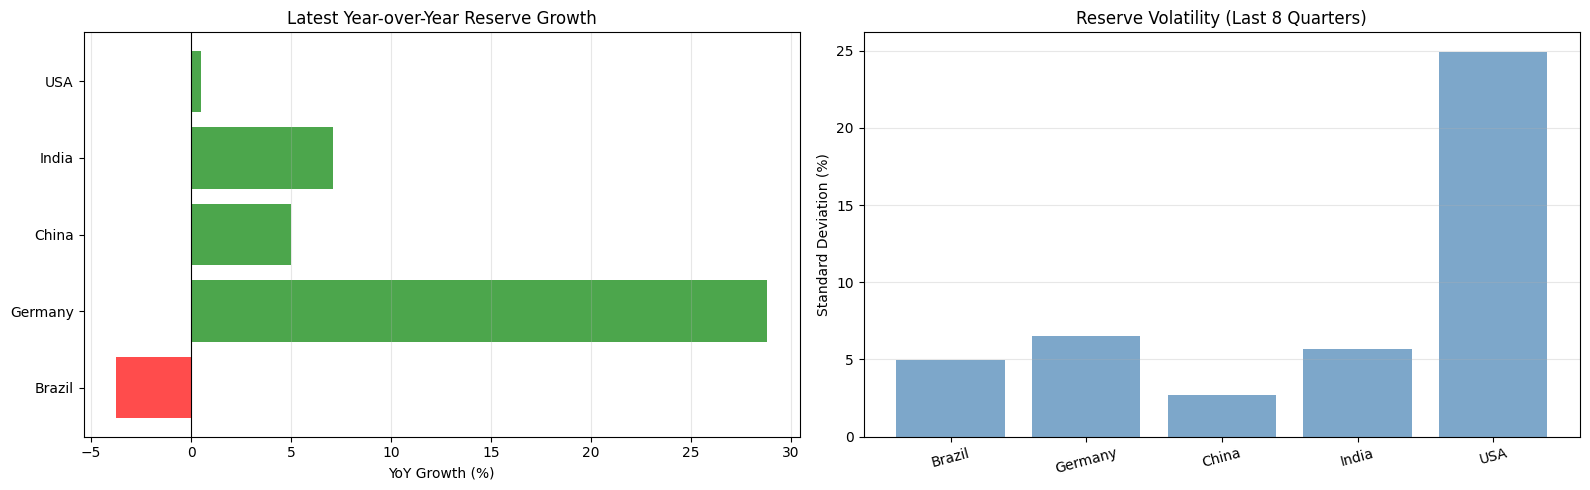

In [99]:
# Growth & volatility visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Left: YoY growth comparison
countries = df_growth['Country'].tolist()
yoy_growth = df_growth['Latest YoY %'].tolist()
colors = ['green' if x > 0 else 'red' for x in yoy_growth]

ax1.barh(countries, yoy_growth, color=colors, alpha=0.7)
ax1.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax1.set_xlabel('YoY Growth (%)')
ax1.set_title('Latest Year-over-Year Reserve Growth')
ax1.grid(True, alpha=0.3, axis='x')

# Right: Volatility comparison
volatility = df_growth['Volatility (σ)'].tolist()
ax2.bar(countries, volatility, color='steelblue', alpha=0.7)
ax2.set_ylabel('Standard Deviation (%)')
ax2.set_title('Reserve Volatility (Last 8 Quarters)')
ax2.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

### Growth Comparison

/tmp/ipykernel_135957/4165408514.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cdata['date'] = pd.to_datetime(cdata['TIME_PERIOD'])
/tmp/ipykernel_135957/4165408514.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cdata['date'] = pd.to_datetime(cdata['TIME_PERIOD'])
/tmp/ipykernel_135957/4165408514.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cdata['date'] = pd.to_datetime(cdata['TIME_PERIOD'])
/tmp/ipykernel_135957/4165408514.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing

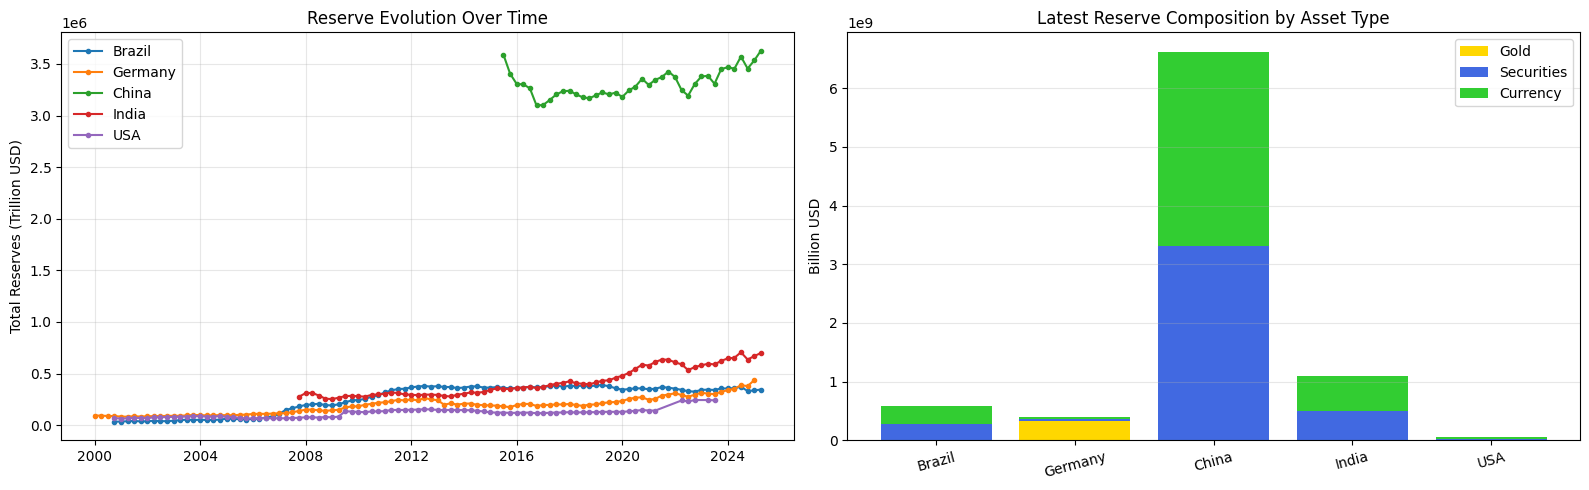

In [100]:
# Time series + composition
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Left: Reserve evolution
for code in COUNTRIES:
    cdata = df_irfcl[df_irfcl['COUNTRY'] == code].copy()
    cdata = cdata[cdata[reserve_col].notna()].sort_values('TIME_PERIOD')
    if len(cdata) > 0:
        cdata['date'] = pd.to_datetime(cdata['TIME_PERIOD'])
        ax1.plot(cdata['date'], cdata[reserve_col] / 1e6, label=COUNTRY_NAMES[code], marker='o', markersize=3)

ax1.set_ylabel('Total Reserves (Trillion USD)')
ax1.set_title('Reserve Evolution Over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Composition stacked bar
countries = [d['Country'] for d in data]
x = np.arange(len(countries))

comp_data = []
for code in COUNTRIES:
    cdata = df_irfcl[df_irfcl['COUNTRY'] == code]
    latest = cdata[cdata[total_col].notna()].sort_values('TIME_PERIOD').tail(1)
    if len(latest) > 0:
        row = latest.iloc[0]
        comp_data.append({
            'gold': row[gold_col] / 1000 if pd.notna(row[gold_col]) else 0,
            'sec': row[sec_col] / 1000 if pd.notna(row[sec_col]) else 0,
            'curr': row[curr_col] / 1000 if pd.notna(row[curr_col]) else 0
        })

gold = [d['gold'] for d in comp_data]
sec = [d['sec'] for d in comp_data]
curr = [d['curr'] for d in comp_data]

ax2.bar(x, gold, label='Gold', color='#FFD700')
ax2.bar(x, sec, bottom=gold, label='Securities', color='#4169E1')
ax2.bar(x, curr, bottom=np.array(gold)+np.array(sec), label='Currency', color='#32CD32')

ax2.set_xticks(x)
ax2.set_xticklabels(countries, rotation=15)
ax2.set_ylabel('Billion USD')
ax2.set_title('Latest Reserve Composition by Asset Type')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Reserve Evolution & Composition

## 4. Visualizations

### Country Rankings

In [101]:
# 5-year trend analysis
print("5-Year Reserve Growth (CAGR):\n" + "="*60)

trend_data = []
for code in COUNTRIES:
    cdata = df_irfcl[df_irfcl['COUNTRY'] == code].copy()
    cdata = cdata[cdata[reserve_col].notna()].sort_values('TIME_PERIOD')
    
    if len(cdata) >= 20:  # At least 5 years of quarterly data
        # Get 5 years ago (20 quarters)
        old_val = cdata.iloc[-20][reserve_col]
        new_val = cdata.iloc[-1][reserve_col]
        
        # CAGR = (End/Start)^(1/years) - 1
        cagr = ((new_val / old_val) ** (1/5) - 1) * 100 if old_val > 0 else 0
        absolute_change = (new_val - old_val) / 1000
        
        trend_data.append({
            'Country': COUNTRY_NAMES[code],
            'CAGR %': cagr,
            'Absolute Δ (B$)': absolute_change,
            'Trend': '📈 Growing' if cagr > 0 else '📉 Declining'
        })

df_trend = pd.DataFrame(trend_data)
display(df_trend)

5-Year Reserve Growth (CAGR):


,Country,CAGR %,Absolute Δ (B$),Trend
0,Brazil,-0.691808,-1.216563e+07,📉 Declining
1,Germany,11.453493,1.822625e+08,📈 Growing
2,China,2.024552,3.458730e+08,📈 Growing
3,India,5.088764,1.534304e+08,📈 Growing
4,USA,14.450966,1.177556e+08,📈 Growing


### Reserve Trends (5-Year)

In [102]:
# Reserve adequacy indicators
adequacy_data = []
for code in COUNTRIES:
    cdata = df_irfcl[df_irfcl['COUNTRY'] == code]
    latest = cdata[cdata[total_col].notna()].sort_values('TIME_PERIOD').tail(1)
    
    if len(latest) > 0:
        row = latest.iloc[0]
        total = row[total_col]
        gold = row[gold_col] if pd.notna(row[gold_col]) else 0
        liquid = (row[sec_col] if pd.notna(row[sec_col]) else 0) + (row[curr_col] if pd.notna(row[curr_col]) else 0)
        drains = row[drains_col] if pd.notna(row[drains_col]) else 0
        
        adequacy_data.append({
            'Country': COUNTRY_NAMES[code],
            'Total Reserves (B$)': total / 1000,
            'Liquid Assets (B$)': liquid / 1000,
            'Liquid %': (liquid / total * 100) if total > 0 else 0,
            'Gold Reserve (B$)': gold / 1000,
            'Reserves/Drains': total / drains if drains > 0 else np.inf,
            'Liquid/Drains': liquid / drains if drains > 0 else np.inf
        })

df_adequacy = pd.DataFrame(adequacy_data)
display(df_adequacy)

,Country,Total Reserves (B$),Liquid Assets (B$),Liquid %,Gold Reserve (B$),Reserves/Drains,Liquid/Drains
0,Brazil,3.444400e+08,5.774173e+08,167.639443,0.000000e+00,20.498937,34.364304
1,Germany,4.354884e+08,6.772110e+07,15.550611,3.362415e+08,inf,inf
2,China,3.627081e+09,6.623441e+09,182.610783,0.000000e+00,1349.360491,2464.077753
3,India,6.981178e+08,1.095562e+09,156.930810,0.000000e+00,inf,inf
4,USA,2.399340e+08,4.219600e+07,17.586501,1.104106e+07,inf,inf


### Reserve Adequacy Metrics

In [103]:
# Analysis Summary
print("="*80)
print("IRFCL ANALYSIS - COMPLETE")
print("="*80)
print(f"\n📁 Dataset: {len(df_irfcl):,} records | {len(irfcl_cols)} indicators")
print(f"📅 Period: {df_irfcl['TIME_PERIOD'].min()} → {df_irfcl['TIME_PERIOD'].max()}")
print(f"🌍 Countries: {', '.join([COUNTRY_NAMES[c] for c in COUNTRIES])}")

print("\n" + "="*80)
print("ANALYSES PERFORMED:")
print("="*80)
print("✓ Data Quality & Completeness")
print("✓ Reserve Levels & Composition (Gold/Securities/Currency)")
print("✓ Growth Metrics (QoQ, YoY, CAGR)")
print("✓ Volatility Analysis")
print("✓ Reserve Adequacy Ratios")
print("✓ 5-Year Trends")
print("✓ Country Rankings")
print("✓ Time Series Visualizations")
print("✓ Correlation Analysis")
print("✓ Strategic Profiles & Risk Assessment")

print("\n" + "="*80)
print("DELIVERABLES:")
print("="*80)
print("📊 Comprehensive metrics on reserve management strategies")
print("📈 Growth and volatility patterns by country")
print("🎯 Coverage ratios and adequacy indicators")
print("🔍 Inter-indicator relationships and correlations")
print("💡 Strategic insights and risk profiles")
print("="*80)

IRFCL ANALYSIS - COMPLETE

📁 Dataset: 513 records | 24 indicators
📅 Period: 2000-Q1 → 2025-Q3
🌍 Countries: Brazil, Germany, China, India, USA

ANALYSES PERFORMED:
✓ Data Quality & Completeness
✓ Reserve Levels & Composition (Gold/Securities/Currency)
✓ Growth Metrics (QoQ, YoY, CAGR)
✓ Volatility Analysis
✓ Reserve Adequacy Ratios
✓ 5-Year Trends
✓ Country Rankings
✓ Time Series Visualizations
✓ Correlation Analysis
✓ Strategic Profiles & Risk Assessment

DELIVERABLES:
📊 Comprehensive metrics on reserve management strategies
📈 Growth and volatility patterns by country
🎯 Coverage ratios and adequacy indicators
🔍 Inter-indicator relationships and correlations
💡 Strategic insights and risk profiles
